# Final extraction
There are 2 options for a final extraction:
1. Directly take the binned flux (see Tikhonov_extraction.ipynb)
2. 2D decontamination + box-like extraction

This notebook focuses on the second options (the first option is shown in other notebooks)

## Imports

In [1]:
# Imports for plots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

# Imports from standard packages
# from scipy.interpolate import interp1d
from astropy.io import fits
import numpy as np

# Imports for extraction
from extract.overlap import TrpzOverlap, TrpzBox
from extract.throughput import ThroughputSOSS
from extract.convolution import WebbKer

### Matplotlib defaults

In [2]:
%matplotlib inline

In [3]:
plt.rc('figure', figsize=(9,3))
plt.rcParams["image.cmap"] = "inferno"

## Read ref files

In [4]:
# List of orders to consider in the extraction
order_list = [1, 2]

#### Wavelength solution ####
wave_maps = []
wave_maps.append(fits.getdata("extract/Ref_files/wavelengths_m1.fits"))
wave_maps.append(fits.getdata("extract/Ref_files/wavelengths_m2.fits"))

#### Spatial profiles ####
spat_pros = []
spat_pros.append(fits.getdata("extract/Ref_files/spat_profile_m1.fits").squeeze())
spat_pros.append(fits.getdata("extract/Ref_files/spat_profile_m2.fits").squeeze())

# Convert data from fits files to float (fits precision is 1e-8)
wave_maps = [wv.astype('float64') for wv in wave_maps]
spat_pros = [p_ord.astype('float64') for p_ord in spat_pros]

#### Throughputs ####
thrpt_list = [ThroughputSOSS(order) for order in order_list]

#### Convolution kernels ####
ker_list = [WebbKer(wv_map) for wv_map in wave_maps]

# Put all inputs from reference files in a list
ref_files_args = [spat_pros, wave_maps, thrpt_list, ker_list]

## Load simulation

In [5]:
# Import custom function to read toy simulation
from sys import path
path.append("Fake_data")
from simu_utils import load_simu
# Load a simulation
simu = load_simu("Fake_data/phoenix_teff_02300_scale_1.0e+02.fits")
data = simu["data"]

## Extraction

### Parameters
(Example using with few inputs parameters)

In [6]:
params = {}

# Map of expected noise (sig)
bkgd_noise = 20.

# Oversampling
params["n_os"] = 3

# Threshold on the spatial profile
params["thresh"] = 1e-4

### Init extraction object
(This can be done only once if the `n_os` doesn't change)

In [7]:
extra = TrpzOverlap(*ref_files_args, **params)

### Extract
Here, we run a really simple extraction (only one step, no tikhonov). <br>
In reality, this is were the "solver" should be used to iterate and get the best extraction as possible.

In [8]:
# Noise estimate to weight the pixels
# Poisson noise + background noise
sig = np.sqrt(data + bkgd_noise**2)

# Extract
f_k = extra.extract(data=data, sig=sig)

## Quality estimate

### Rebuild the detector

In [9]:
rebuilt = extra.rebuild(f_k)

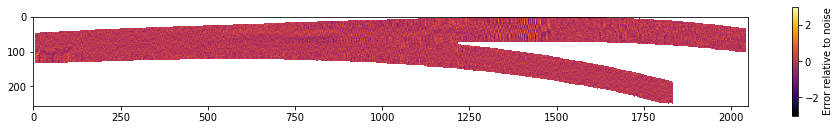

In [10]:
plt.figure(figsize=(16,2))
plt.imshow((rebuilt-data)/sig, vmin=-3, vmax=3)
plt.colorbar(label="Error relative to noise")

## Decontaminate the 2d image
Generate a decontaminated image for each order

In [11]:
data_decont = []
for i_ord in range(extra.n_ord):
    # Rebuild the contaminating order
    rebuilt = extra.rebuild(f_k, orders=[i_ord])
    
    # Remove this order and save
    data_decont.append(data - rebuilt)

# Flip so the first order is in first position
data_decont = np.flip(data_decont, axis=0)

## Get 1d spectrum with box-like extraction
More details for box-like extraction in Box_like_extraction.ipynb

In [12]:
# Use a single row for final wavelength bin
grid_box_list = [wv_map[50, :] for wv_map in wave_maps]
# Keep well defined values and sort
grid_box_list = [np.unique(wv[wv > 0.])
                 for wv in grid_box_list]
f_bin_list = []

# Iterate on each orders
for i_ord in range(extra.n_ord):
    # Reference files
    wv_map = extra.lam_list[i_ord]
    aperture = extra.p_list[i_ord]
    
    # Mask
    mask = np.isnan(data_decont[i_ord])
    
    # Define extraction object
    box_extra = TrpzBox(aperture, wv_map, box_width=30, mask=mask)
    
    # Extract the flux
    f_k = box_extra.extract(data=data_decont[i_ord])

    # Bin to pixels
    grid_box = grid_box_list[i_ord]
    _, f_bin = box_extra.bin_to_pixel(grid_pix=grid_box, f_k=f_k)
    
    # Save
    f_bin_list.append(f_bin)

The final output is in f_bin_list (for each orders)

Text(0.5, 0, 'Wavelength [$\\mu m$]')

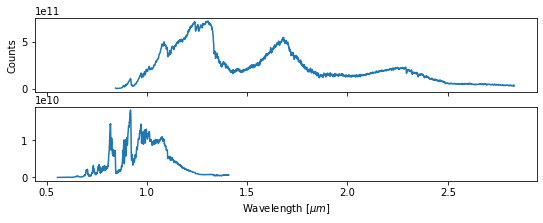

In [13]:
fig, ax = plt.subplots(2, 1, sharex=True)
for i_ord in range(extra.n_ord):
    ax[i_ord].plot(grid_box_list[i_ord], f_bin_list[i_ord])
    
ax[0].set_ylabel("Counts")
ax[1].set_xlabel("Wavelength [$\mu m$]")